# Visualizing optimization results

Tim Head, August 2016.

In [1]:
import numpy as np
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

Bayesian optimization or sequential model-based optimization uses a surrogate model
to model the expensive to evaluate objective function `func`. It is this model
that is used to determine at which points to evaluate the expensive objective next.

To help understand why the optimization process is proceeding the way it is, it is
useful to plot the location and order of the points at which the objective is
evaluated. If everything is working as expected, early samples will be spread over
the whole parameter space and later samples should cluster around the minimum.

The `plot_evaluations()` function helps with visualizing the location and order
in which samples are evaluated for objectives with an arbitrary number of dimensions.

The `plot_objective()` function plots the partial dependence of the objective, as
represented by the surrogate model, for each dimension and as pairs of the input
dimensions.

All of the minimizers implemented in `skopt` return an [`OptimizeResult`]() instance
that can be inspected. Both `plot_evaluations` and `plot_objective` are helpers that
do just that.


## Toy models

We will use two different toy models to demonstrate how `plot_evaluations()` works.

The first model is the `branin` function which has two dimensions and three minima.

The second model is the `hart6` function which has six dimension which makes it hard to visualize. This will show off the utility of `plot_evaluations()`.

In [2]:
from skopt.benchmarks import branin as branin
from skopt.benchmarks import hart6 as hart6_


# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x):
    return hart6_(x[:6])

## Starting with `branin`

To start let's take advantage of the fact that `branin` is a simple
function which can be visualised in two dimensions.

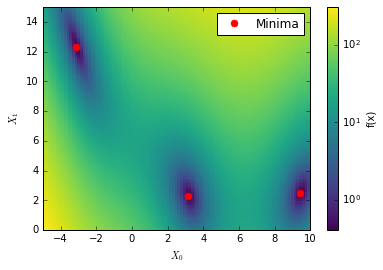

In [3]:
from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc="best", numpoints=1)
    
    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])
    
plot_branin()

## Evaluating the objective function

Next we use an extra trees based minimizer to find one of the minima of the
`branin` function. Then we visualize at which points the objective is being
evaluated using `plot_evaluations()`.

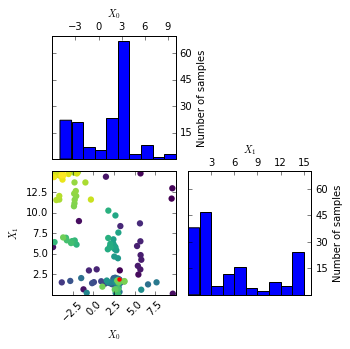

In [4]:
from functools import partial
from skopt.plots import plot_evaluations
from skopt import gp_minimize, forest_minimize, dummy_minimize


bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 160

forest_res = forest_minimize(branin, bounds, n_calls=n_calls, base_estimator="ET",
                             random_state=4)

_ = plot_evaluations(forest_res, bins=10)

`plot_evaluations()` creates a grid of size `n_dims` by `n_dims`. The diagonal shows
histograms for each of the dimensions. In the lower triangle (just one plot in this case)
a two dimensional scatter plot of all points is shown. The order in which points were
evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier
samples and lighter/yellow colors correspond to later samples. A red point shows the location
of the minimum found by the optimization process.

You should be able to see that points start clustering around the location of the true
miminum. The histograms show that the objective is evaluated more often at locations near
to one of the three minima.

Using `plot_objective()` we can visualise the one dimensional partial dependence of the
surrogate model for each dimension. The contour plot in the bottom left corner shows
the two dimensional partial dependence. In this case this is the same as simply plotting
the objective as it only has two dimensions.

> ### Partial dependence plots
>
> Partial dependence plots were proposed by [Friedman (2001)](http://projecteuclid.org/euclid.aos/1013203451) (doi:10.1214/aos/1013203451 section 8.2)
> as a method for interpreting the importance of input features used in gradient
> boosting machines. Given a function of $k$ variables $y=f\left(x_1, x_2, ..., x_k\right)$ the
> partial dependence of $f$ on the $i$-th variable $x_i$ is calculated as:
> $$\phi\left( x_i \right) = \frac{1}{N} \sum^N_{j=0}f\left(x_{1,j}, x_{2,j}, ..., x_i, ..., x_{k,j}\right)$$
> with the sum running over a set of $N$ points drawn at random from the search space.
>
> The idea is to visulize how the value of $x_j$ influences the function $f$ after
> averaging out the influence of all other variables.

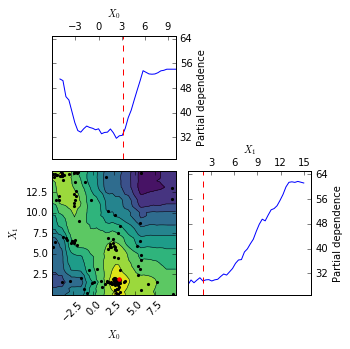

In [5]:
from skopt.plots import plot_objective

_ = plot_objective(forest_res)

The two dimensional partial dependence plot can look like the true objective but it does not
have to. As points at which the objective function is being evaluated are concentrated
around the suspected minimum the surrogate model sometimes is not a good
representation of the objective far away from the minima.

## Random sampling

Compare this to a mimizer which picks points at random. There is no structure visible
in the order in which it evaluates the objective. Because there is no model involved
in the process of picking sample points at random, we can not plot the partial
dependence of the model.

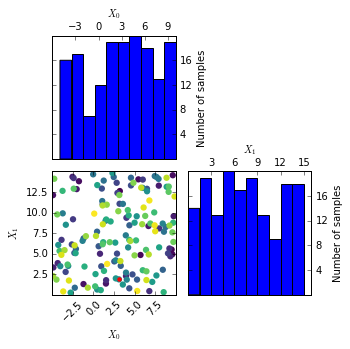

In [6]:
dummy_res = dummy_minimize(branin, bounds, n_calls=n_calls, random_state=4)

_ = plot_evaluations(dummy_res, bins=10)

## Working in six dimensions

Visualising what happens in two dimensions is easy, where `plot_evaluations()` and
`plot_objective()` start to be useful is when the number of dimensions grows.
They take care of many of the more mundane things needed to make good plots of all combinations of the dimensions.

The next example uses `hart6` which has six dimensions and shows both `plot_evaluations()`
and `plot_objective()`.

In [7]:
bounds = [(0., 1.),] * 6

forest_res = forest_minimize(hart6, bounds, n_calls=n_calls,
                             base_estimator="ET", random_state=4)

In [ ]:
_ = plot_evaluations(forest_res)
_ = plot_objective(forest_res)

## Going from 6 to 6+2 dimensions

To make things more interesting let's add two dimension to the problem. As `hart6`
only depends on six dimensions we know that for this problem the new dimensions will
be "flat" or uninformative. This is clearly visible in both the placement of samples
and the partial dependence plots.

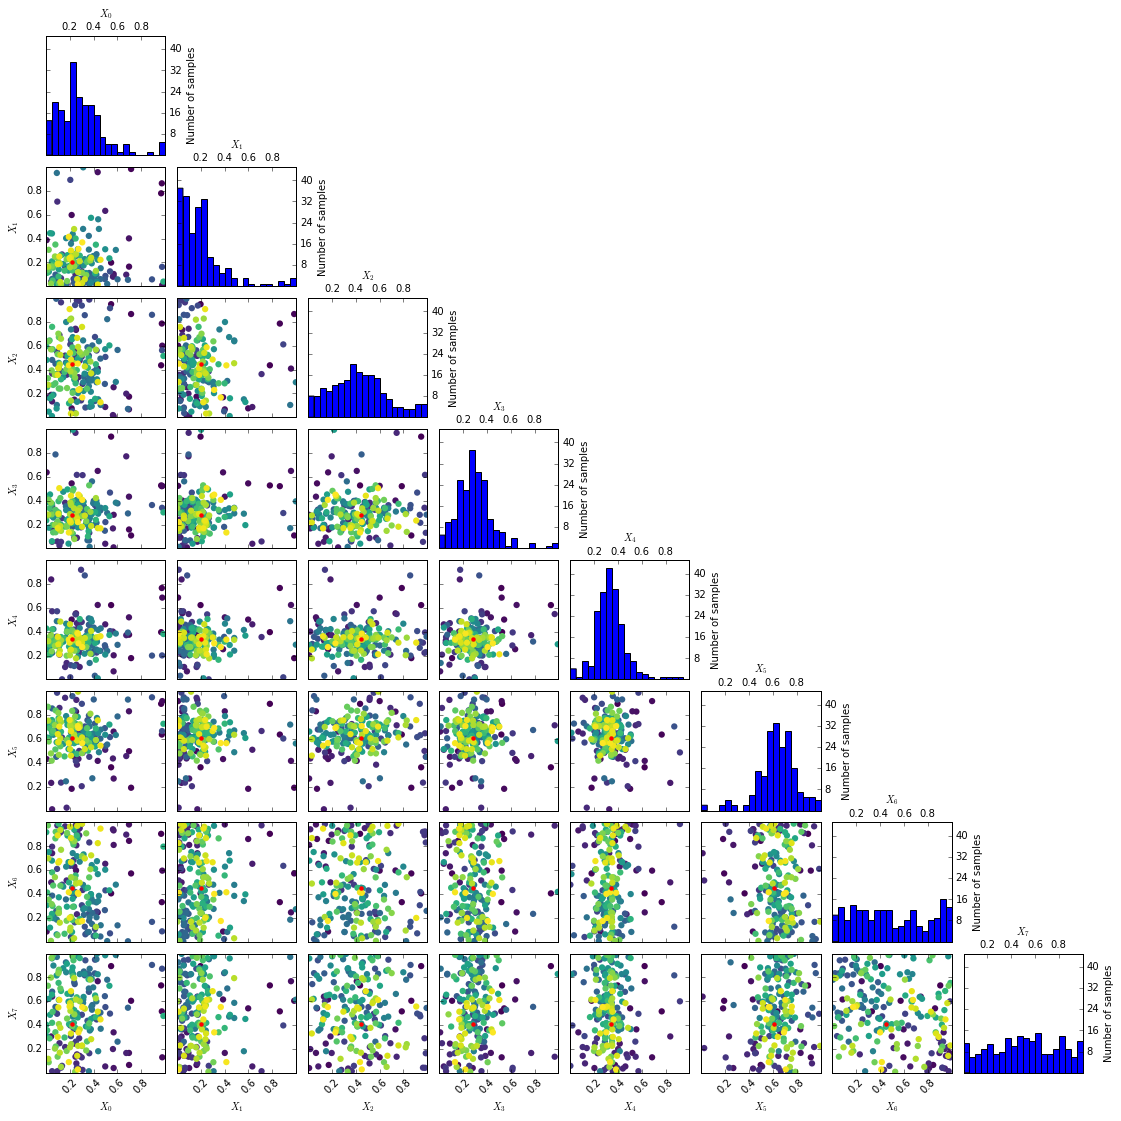

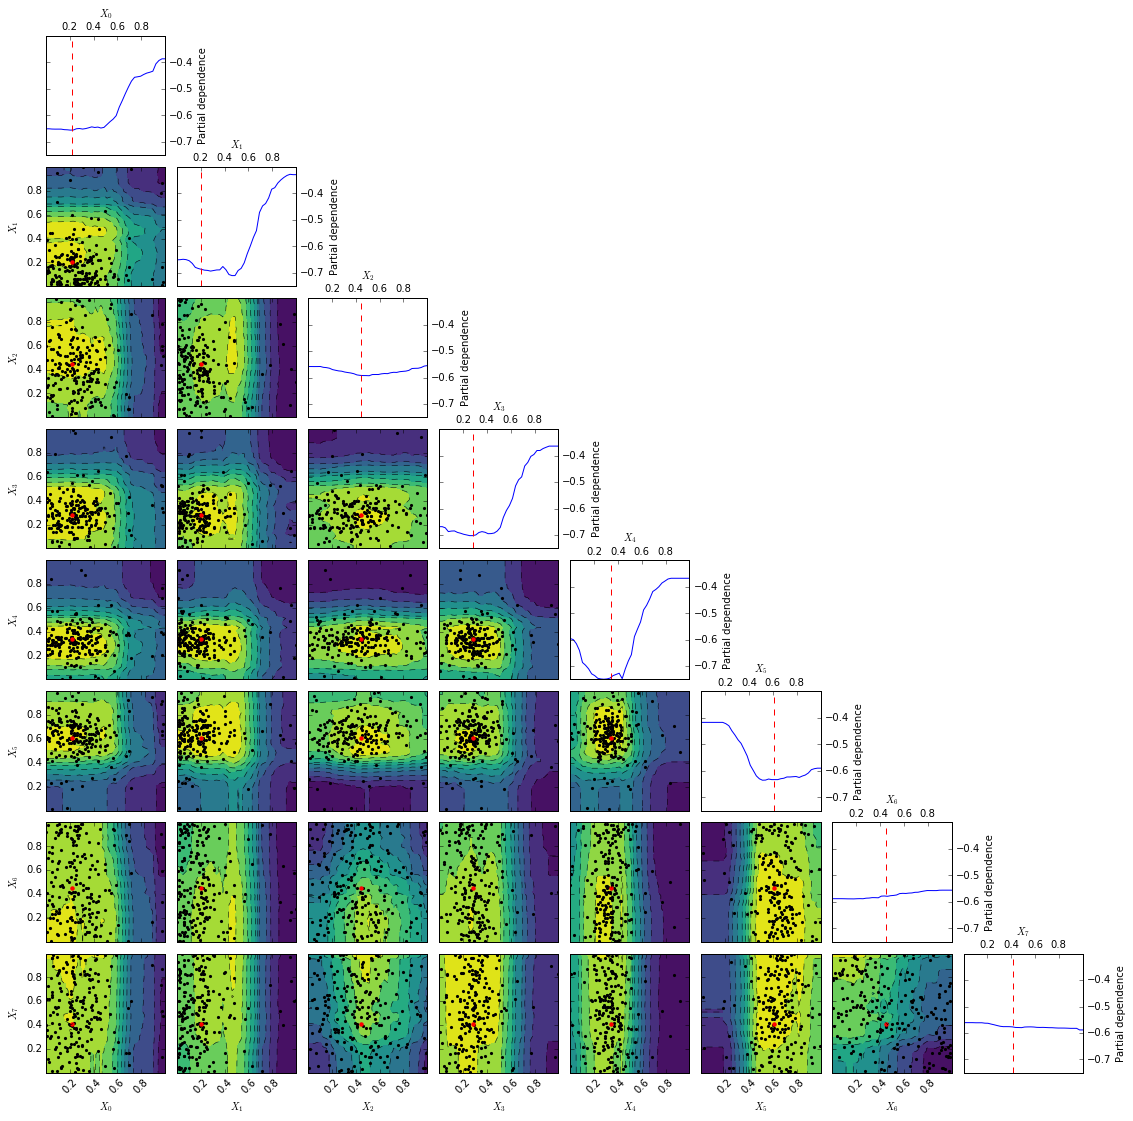

In [9]:
bounds = [(0., 1.),] * 8
n_calls = 200

forest_res = forest_minimize(hart6, bounds, n_calls=n_calls,
                             base_estimator="ET", random_state=4)

_ = plot_evaluations(forest_res)
_ = plot_objective(forest_res)